# Mini-projet: Débruitage d'image

Dans ce mini-projet, nous nous intéressons à différents algorithmes basés sur la transformée de Fourier, qui permettent de débruiter une image en niveaux de gris. 

D'un point de vue mathématique, une fois échantillonnée, une image n'est rien d'autre qu'un tableau de nombres, chaque nombre codant pour un niveau de gris (0: noir, 255: blanc pour une image encodée sur 8 bits, soit 256 valeurs). Il est donc possible, à l'instar de n'importe quel signal numérique, de calculer sa transformée de Fourier discrète, donnée pour une image de taille $N \times N$ par:

$$
\hat{f}[p, q] = \sum_{x = 1}^N \sum_{y = 1}^N f[x, y]\exp \bigg[i \dfrac{2 \pi }{N}(p x + q y)\bigg ].
$$


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import ndimage

In [4]:
# Load the image using scikit-image library
from skimage.io import imread
img = imread("lena.png")
nx, ny = img.shape
npixels = nx*ny

## QUESTION 1: Approximation linéaire dans l'espace de Fourier

Une propriété très intéressante des images vis à vis de la transformée de Fourier est que ces dernières possèdent très souvent une représentation parcimonieuse dans l'espace de Fourier: si on calcule la transformée de Fourier d'une image, on constate ainsi que la valeur de la plupart des coefficients de Fourier est très souvent négligeable, de sorte que l'image est très bien approximée par la somme de ses modes de Fourier de plus grande amplitude. 

Calculer la transformée de Fourier de l'image *lena.png*, et implémenter une fonction qui reconstruit l'image originale en ne conservant que les coefficients de Fourier correspondant aux $K$ fréquences les plus basses (approximation dite *linéaire* de l'image). On peut quantifier l'erreur de reconstruction en considérant la quantité:

$$
\Delta = \dfrac{\|I - I_r\|_2}{N}
$$

où $I$ (resp. $I_r$) est l'image originale (resp. reconstruite à partir des $K$ fréquences les plus basses), $\|\dot\|_2$ la norme $L^2$ et $N$ le nombre de pixels dans l'image. Pour quelle valeur de $K$ obtient-on $\Delta < 0.3$? $\Delta < 0.1$? L'approximation linéaire est-t'elle intéressante en terme de compression?



In [10]:
# to complete

def linear_approximation(img, nfreqs):
    """
    Linear approximation of the image
    
    :param img: Input image
    :type img: 2D numpy array
    :param nfreqs: Number of frequencies to keep in each direction
    :type nfreqs: int
    
    :return: Compressed image
    :rtype: 2D numpy array
    """

    # Calculate 2D Fourier transform    
    fourier = scipy.fft.fft2(img)

    print(fourier.shape)

    range_left = int(nfreqs / 2)
    range_right = nfreqs - range_left

    # Compress fourier transform
    fourier_comp = fourier.copy()
    fourier_comp[range_left:-range_right, range_left:-range_right] = 0

    # Calculate inverse transform
    img_comp = scipy.fft.ifft2(fourier_comp)

    return np.real(img_comp)


(567, 567)


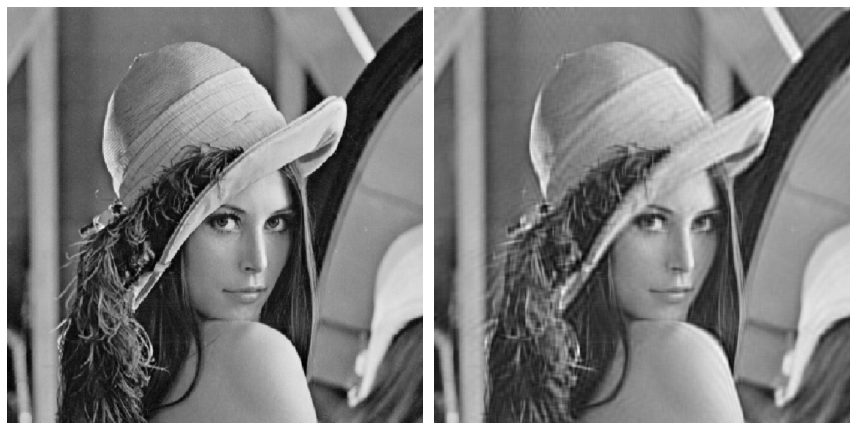

In [16]:
img_approx_linear = linear_approximation(img, 60)

fig, ax = plt.subplots(1, 2, figsize=(12, 24), sharex=True, sharey=True)
ax[0].imshow(img, cmap='gray')
ax[1].imshow(img_approx_linear, cmap='gray')
for a in ax.ravel():
    a.set_axis_off()
plt.tight_layout()
plt.show()

In [17]:
deltaLin = np.linalg.norm(img - img_approx_linear) / img.size
print(f'Erreur de reconstruction : {deltaLin}')

Erreur de reconstruction : 0.015416116189522908


## QUESTION 2: Approximation non-linéaire


Implémenter une fonction qui reconstruit l'image originale en ne conservant que les $K$ coefficients de Fourier dont les amplitudes sont maximales (approximation dite *non-linéaire* de l'image) et en fixant les autres coefficients à $0$. Pour quelle valeur de $K$ obtient-on $\Delta < 0.1$? Commenter les résultats obtenus pour différentes valeurs de $K$. 

In [81]:
def nonlinear_approximation(img, ncoeffs):
    """
    Non-linear approximation of the image
    
    :param img: input image
    :type img: 2D numpy array
    :param ncoeffs: number of Fourier coefficients to keep
    :type nfreqs: int
    
    :return: compressed image
    :rtype: 2D numpy array
    """

    # Calculate 2D Fourier transform    
    fourier_norm = scipy.fft.fft2(img) / 567**2
    
    thresh = 0.2
    fourier_comp = fourier_norm * (abs(fourier_norm) > thresh)
 
    # Calculate inverse transform
    img_comp = scipy.fft.ifft2(fourier_comp)

    return np.real(img_comp)

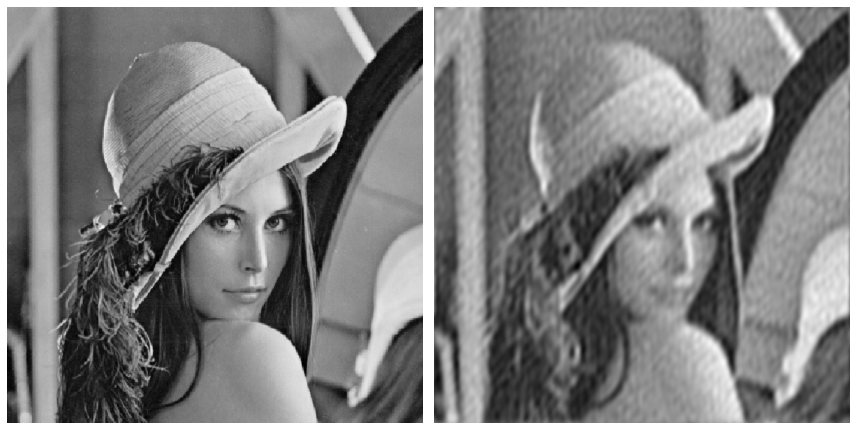

In [82]:
# Représenter sur le même plot l'image et son approximation, pour différents choix de "ncoeffs"
img_approx_nonlinear = nonlinear_approximation(img, 30)

fig, ax = plt.subplots(1, 2, figsize=(12, 24), sharex=True, sharey=True)
ax[0].imshow(img, cmap='gray')
ax[1].imshow(img_approx_nonlinear, cmap='gray')
for a in ax.ravel():
    a.set_axis_off()
plt.tight_layout()
plt.show()

In [83]:
deltaNonLin = np.linalg.norm(img - img_approx_nonlinear) / img.size
print(f'Erreur de reconstruction : {deltaNonLin}')

Erreur de reconstruction : 0.22439958415223146


## QUESTION 3: Image bruitée

Bruiter l'image par un bruit gaussien additif de moyenne nulle et d'écart-type $\sigma = 15$. Afficher l'image originale et l'image bruitée, ainsi que le bruit et la transformée de Fourier du bruit. Comment expliquer la similitude entre les représentations du bruit dans l'espace physique et dans l'espace fréquenciel?


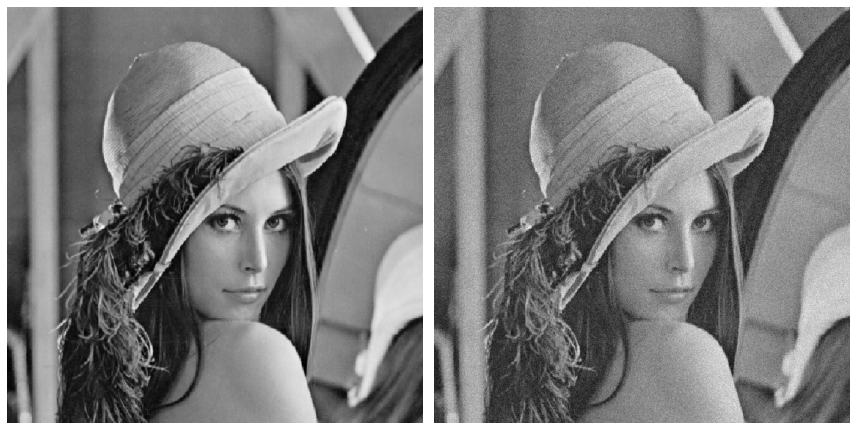

In [84]:
# Generate gaussian noise array
noise_array = np.random.normal(0., 15., img.shape)

# Apply additive noise to image
img_noise = img + noise_array

# Plot images
fig, ax = plt.subplots(1, 2, figsize=(12, 24), sharex=True, sharey=True)
ax[0].imshow(img, cmap='gray')
ax[1].imshow(img_noise, cmap='gray')
for a in ax.ravel():
    a.set_axis_off()
plt.tight_layout()
plt.show()

## QUESTION 4: Débruitage par seuillage des coefficients de Fourier

La transformée de Fourier du bruit semble être répartie relativement uniformément sur l'ensemble des coefficients de Fourier. A l'inverse, on a vu dans la question 2 que l'essentiel de l'énergie de l'image se concentre sur un nombre restreint de coefficients. Une méthode possible pour débruiter l'image peut donc consister à débruiter l'image en fixant à zéro tous les coefficients de Fourier dont l'amplitude dépasse un certain seuil. Débruiter l'image en fixant un seuil au-dessous duquel les coefficients de Fourier sont fixés à zéro. Commenter le résultat obtenu. 

In [85]:
def fourier_thresholding(img, threshold):
    
    """
    Denoising by thresholding in a Fourier basis
    
    :param img: noisy image
    :type img: 2D numpy array
    
    :return: denoised image
    :rtype: 2D numpy array
    """
    
    # Calculate 2D Fourier transform
    fourier = scipy.fft.fft2(img)

    # Calculate Fourier amplitudes
    amplitudes = np.abs(fourier)

    # 
    amplitudes_mask = amplitudes > threshold

    # 
    fourier_thresholded = fourier.copy()
    fourier_thresholded[amplitudes_mask] = 0.

    # Calculate inverse transform
    img_thresholded = scipy.fft.ifft2(fourier_thresholded)

    return np.real(img_thresholded)
    

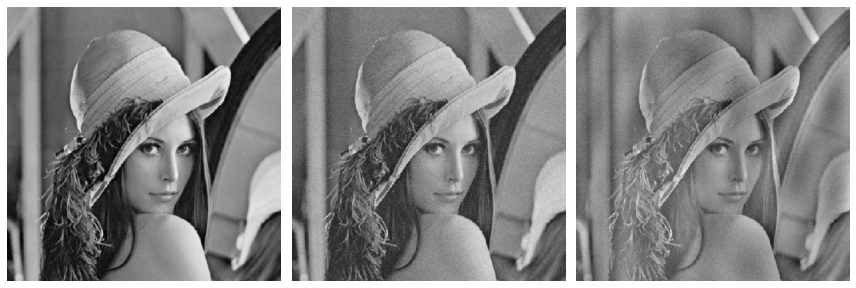

In [86]:
# Calculate thresholded image
img_thresholded = fourier_thresholding(img_noise, 1e6)

# Plot images
fig, ax = plt.subplots(1, 3, figsize=(12, 24), sharex=True, sharey=True)
ax[0].imshow(img, cmap='gray')
ax[1].imshow(img_noise, cmap='gray')
ax[2].imshow(img_thresholded, cmap='gray')
for a in ax.ravel():
    a.set_axis_off()
plt.tight_layout()
plt.show()

## QUESTION 5: Filtre médian

Une autre approche pour filtrer l'image consiste à remplacer la valeur de chaque pixel par la valeur médiane mesurée dans un voisinage du pixel. Implémenter le filtrage proposé pour un voisinage carré de taille $s$ fixée et appliquer les filtres sur l'image. Commenter le résultat. Pourquoi avoir choisi la médiane dans le voisinage plutôt que la moyenne?

In [87]:
def median_filter(img, size):
    
    """
    Median filter
    
    :param img: Input image
    :type img: 2D numpy array
    :param size: Size of the square neighborhood used to compute the filtering
    :type size: int
    
    :return: filtered image
    :rtype: 2D numpy array
    """

    new = scipy.ndimage.median_filter(img, size=size)

    return new
            

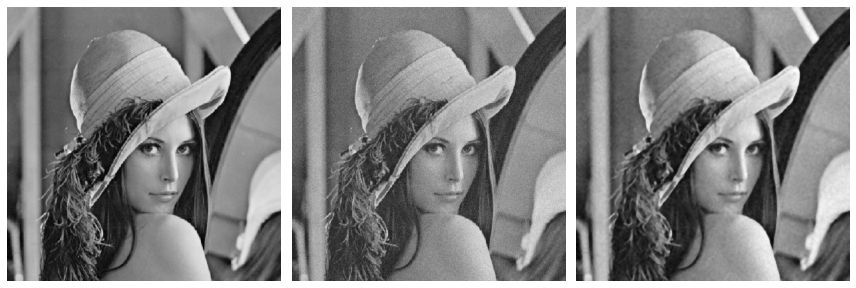

In [88]:
# Calculate thresholded image
img_median_filter = median_filter(img_noise, 5)

# Plot images
fig, ax = plt.subplots(1, 3, figsize=(12, 24), sharex=True, sharey=True)
ax[0].imshow(img, cmap='gray')
ax[1].imshow(img_noise, cmap='gray')
ax[2].imshow(img_median_filter, cmap='gray')
for a in ax.ravel():
    a.set_axis_off()
plt.tight_layout()
plt.show()

## QUESTION 6: Filtre Gaussien

Une autre méthode de filtrage populaire consiste à filtrer l'image par un noyau Gaussien, défini par:

$$
G(x, y) = \dfrac{1}{2 \pi \sigma^2 }\exp \bigg (\dfrac{x^2 + y^2}{2 \sigma ^2} \bigg ).
$$

Implémenter le filtrage et l'appliquer à l'image bruitée. Donner une interprétation du fonctionnement du filtre.

In [91]:
import scipy.stats as st

def gkern(kernlen=567, nsig=3):
    """Returns a 2D Gaussian kernel."""
    x = np.linspace(-nsig, nsig, kernlen+1)
    kern1d = np.diff(st.norm.cdf(x))
    kern2d = np.outer(kern1d, kern1d)
    return kern2d / kern2d.sum()

def gaussian_filter(img, sig=3):

    new = scipy.ndimage.gaussian_filter(img, sigma=sig)

    return new

img_gaussian_filter = gaussian_filter(img_noise, 3)

# Plot images
fig, ax = plt.subplots(1, 2, figsize=(12, 24), sharex=True, sharey=True)
ax[0].imshow(img_noise, cmap='gray')
ax[1].imshow(img_gaussian_filter, cmap='gray')
for a in ax.ravel():
    a.set_axis_off()
plt.tight_layout()
plt.show()

NameError: name 'img_comp' is not defined

## QUESTION 7: Equation de la chaleur

Une méthode de débruitage originale, basée sur une équation aux dérivées partielles, consiste à établir une analogie entre la valeur des pixels et une carte de température. On sait en effet qu'un champ de température tend à s'uniformiser au cours du temps. L'évolution d'un champ de température est modélisée par l'équation de la diffusion de la chaleur: 

$$
\dfrac{\partial T}{\partial t} = - \lambda \Delta T
$$

où l'opérateur Laplacien est donné par

$$
\Delta T = \dfrac{\partial ^2 T}{\partial x^2} + \dfrac{\partial ^2 T}{\partial y^2}.
$$
En résolvant l'équation de la chaleur en prenant comme condition initiale l'image bruitée, on parvient ainsi à lisser (et donc débruiter) l'image.

*7.1 Implémenter une fonction permettant de calculer le Laplacien de l'image. On pourra au choix utiliser une discrétisation de type différence finie ou passer par la transformée de Fourier.*

In [90]:
def laplacian(img):
    
    """
    Computes the Laplacian of the image (différences finies)
    
    :param img: input image
    :type img: numpy array
    
    :return: image laplacian
    :rtype: numpy array
    """

    # Initialise result
    laplacian = np.empty_like(img)    

    # Create shifted arrays
    shifted_up = img[2:, 1:-1]
    shifted_down = img[:-2, 1:-1]
    shifted_left = img[1:-1, 2:]
    shifted_right = img[1:-1, :-2]

    normal_cropped = img[1:-1, 1:-1]

    # Compute directional finite derivatives
    d2_vertical = shifted_up + shifted_down - 2 * normal_cropped  # divided by 1**2
    d2_horizontal = shifted_left + shifted_right - 2 * normal_cropped  # divided by 1**2

    # Fill result
    laplacian[1:-1, 1:-1] = d2_horizontal + d2_vertical
    # will be 0 on the edges (good?)

    return laplacian



*7.2 Résoudre l'équation de la diffusion à l'aide d'un schéma explicite en temps*

In [40]:
# to complete (no worko)

def diffusion(img, t, tstep):
    
    """
    Solves the diffusion equation with "img" as initial conditions
    
    :param img: input image
    :type img: numpy array
    :param t: final time
    :type t: float
    :param tstep: time step
    :type tstep: float
    
    :return: image at time t
    :rtype: numpy array
    """

    # Initialise
    img_step = img.copy()
    time = 0.
    lambd = 0.0001

    while time < t:

        # Compute new image
        img_step -= lambd * laplacian(img_step)

        time += tstep
    
    return img_step

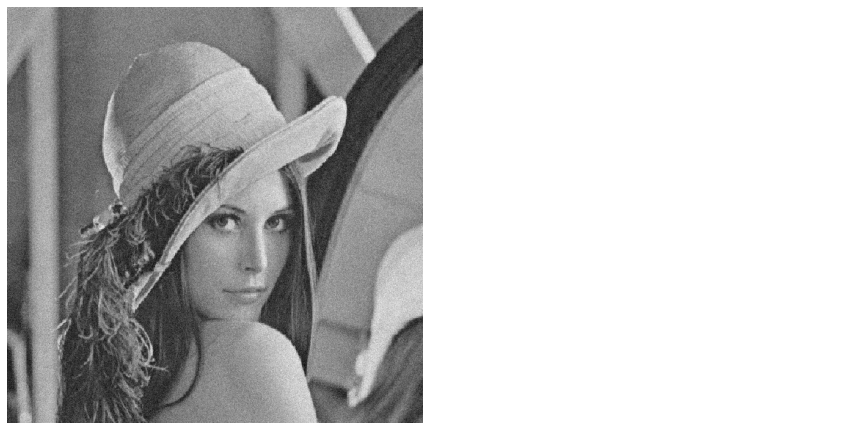

In [41]:
denoised = diffusion(img_noise, 10, 0.01)


# Plot images
fig, ax = plt.subplots(1, 2, figsize=(12, 24), sharex=True, sharey=True)
ax[0].imshow(img_noise, cmap='gray')
ax[1].imshow(denoised, cmap='gray')
for a in ax.ravel():
    a.set_axis_off()
plt.tight_layout()
plt.show()


*7.3 Question bonus: en reprenant les calculs du TP Analyse numérique, montrer que l'équation de la diffusion et le filtrage gaussien sont en fait des méthodes équivalentes.*